#### Problem 3 - a simple, terrifying 2D distribution

Here we will make some data for a population of employees of Monsters Inc$^{\rm TM}$ but we will make the scare score a function of the size (height) of the monster (bigger monster, higher scare score).  We will make the data look like the scare score as function of height (where the gradient is choosen to suit this problem not the real world).

First we make some true height values for the monsters:

$H_{\rm true} \sim \mathcal{N}(2.0, 0.4)$ 

The distribution of the scare scores will be defined as:

$S_{\rm mon} \sim \mathcal{N}(60000 + ((H - 2)*1000), 1000)$.

The scare score is determined by how scared the child is, however the machine measuring this is broken and so has uncertainty of 1500 points.  If we have $N$ monsters which we will label with the index $i = 1,2,..., N$ then the measured scare score will be:

$S_{i, {\rm obs}} \sim \mathcal{N}(S_{i, {\rm true}}, 1500)$.

and finally we have the observed height with the height uncertainty as 0.04m: 

$H_{\rm obs} = \mathcal{N}(H_{\rm true}, 0.4)$

Let's set up this data.

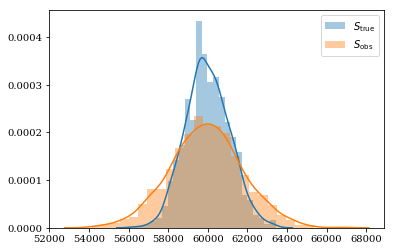

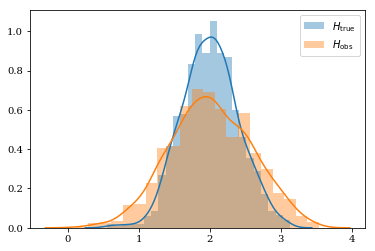

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

N = 1000 #number of samples
Hmu = 2.0 #mean height
Hsigma = 0.4 #height variance
Ssigma = 1000 #scare score variance
alpha = 60000 
beta = 1000.0
H_true = np.random.randn(N) * Hsigma + Hmu
S_true = np.random.randn(N) * Ssigma + (alpha + ((H_true - 2)*beta))
sigma_S_obs = np.ones(N) * 1500
S_obs = S_true + np.random.randn(N) * sigma_S_obs
sigma_H_obs = np.ones(N) * 0.4
H_obs = H_true + np.random.randn(N) * sigma_H_obs                                     
ax = sns.distplot(S_true, label=r'$S_{\rm true}$')
ax = sns.distplot(S_obs, label=r'$S_{\rm obs}$')
ax.legend()
plt.show()
ax = sns.distplot(H_true, label=r'$H_{\rm true}$')
ax = sns.distplot(H_obs, label=r'$H_{\rm obs}$')
ax.legend()

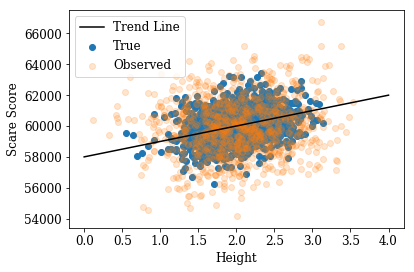

In [27]:
fig, ax = plt.subplots()
from matplotlib import rc
rc("font", family="serif", size=12)
ax.scatter(H_true, S_true, label='True')
ax.scatter(H_obs, S_obs, alpha=0.2, label='Observed')
HH = np.linspace(0, 4, 100)
ax.plot(HH, alpha + (HH - 2) * beta, 'k-', label='Trend Line')
ax.set_xlabel('Height')
ax.set_ylabel('Scare Score')
ax.legend()

It is immediately obvious, that if we were to try an estimate the spread of scare score Magnitudes from the observed data just by measuring the standard deviation we would find an overestimate and would not get any information about the height dependence.

In [28]:
print(f'Observed data: mean = {S_obs.mean():.4f}; std = {S_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {S_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {S_true.mean():.4f}; std = {S_true.std(ddof=1):.4f};  ' +
      f'error on mean = {S_true.std(ddof=1) / N**0.5:.4f}')
print(f'Actual spread around the height relation {Ssigma}')

Observed data: mean = 59917.3399; std = 1841.7868; error on mean = 58.2424
True data: mean = 59985.4243; std = 1109.5195;  error on mean = 35.0861
Actual spread around the Mass relation 1000


What we want is a method that takes the observed data and estimates the spread in the true data.  I guess this can be done a number of ways but here we will look at an HBM using latent variables.  

Let's jump right in a build an acyclic graph to visualise our problem:

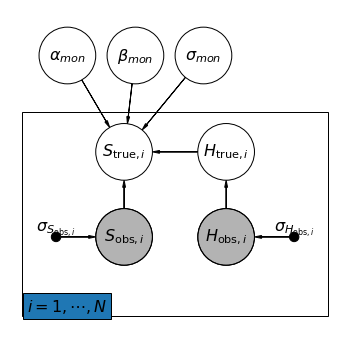

In [29]:
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha_{mon}$", 0.5, 2.6))
pgm.add_node(daft.Node("beta", r"$\beta_{mon}$", 1.1, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{mon}$", 1.7, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("S_true", r"$S_{{\rm true},i}$", 1, 1.75))
pgm.add_node(daft.Node("H_true", r"$H_{{\rm true},i}$", 1.9, 1.75))
# Data.
pgm.add_node(daft.Node("S_obs", r"$S_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("Serr", r"$\sigma_{S_{{\rm obs},i}}$", 0.4, 1.0, fixed=True, offset=[0.0,0.4]))
pgm.add_node(daft.Node("H_obs", r"$H_{{\rm obs},i}$", 1.9, 1, observed=True))
pgm.add_node(daft.Node("Herr", r"$\sigma_{H_{{\rm obs},i}}$", 2.5, 1.0, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("alpha", "S_true")
pgm.add_edge("beta", "S_true")
pgm.add_edge("sigma", "S_true")
pgm.add_edge("H_true", 'S_true')
pgm.add_edge("H_obs", "H_true")
pgm.add_edge("Herr", "H_obs")
pgm.add_edge("S_obs", "S_true")
pgm.add_edge("Serr", "S_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The monsters' scare scores are assumed to follow a height relation with a spread from a Gaussian distribution.  The parameters for the relation and the spread are unknown.  Each monster in $N$ has an index $i$.  Each monster also has a true scare score and true height, which are an unknown, and an scare score and observed height which are known with some uncertainty $\sigma_{S_{{\rm obs},i}}$, and $\sigma_{H_{{\rm obs},i}}$.  We then treat $\alpha$, $\beta$, $\sigma$, , $[S_{{\rm true}, 1}, S_{{\rm true}, 2}, ..., S_{{\rm true}, N}]$, and $[H_{{\rm true}, 1}, H_{{\rm true}, 2}, ..., H_{{\rm true}, N}]$ as parameters that are to be estimated.  

We have the following constraints:

$S_{\rm true} \sim \mathcal{N}(S_{\rm obs}, \sigma_{S_{{\rm obs}}})$.

$H_{\rm true} \sim \mathcal{N}(H_{\rm obs}, \sigma_{H_{{\rm obs}}})$.

That is, the true values of the scare scores must be consistent with the observed values and their uncertainties.

$S_{\rm true} \sim \mathcal{N}(\alpha + (H_{true} - 2)\beta, \sigma)$.


We will also add the following priors that represent our exisitng knowledge of the red clump but are designed to be weakly informative:

$\alpha \sim \mathcal{N}({60000, 1000})$,

$\beta \sim \mathcal{N}(1000, 100)$,

and 

$\sigma \sim {}\rm Lognormal(\log(1000), 0.4)$. 

We can code this up in stan easily!

In [35]:
code = '''
data {
    int N;  // N stars
    real Sobs[N];
    real sigmaSobs[N];
    vector[N] Hobs;
    real sigmaHobs[N];
}
parameters {
    real alpha;
    real<lower = 0> beta;
    real<lower = 0> sigma;
    real Strue[N];
    vector[N] Htrue;
}
model {
    Strue ~ normal(Sobs, sigmaSobs);
    Strue ~ normal(alpha + ((Htrue - 2.0) * beta), sigma);
    Htrue ~ normal(Hobs, sigmaHobs);
    alpha ~ normal(60000, 1000);
    beta ~ normal(1000, 100);
    sigma ~ lognormal(log(1000), 0.4);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56926d8507bc36a7e1805f13c367a552 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpv0uxk75z/stanfit4anon_model_56926d8507bc36a7e1805f13c367a552_6503810339500971147.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We can now run the code.

In [36]:
nchains = 4
data = {'N': N,
       'Sobs': S_obs,
       'sigmaSobs': sigma_S_obs,
       'Hobs': H_obs,
       'sigmaHobs': sigma_H_obs}
fit = sm.sampling(data=data, iter=10000, chains=nchains)

Running the code is simple.  

You can watch the fit proceed in the terminal window.

We can print the fit object to see lots of useful information.  Perhaps most importantly, R_hat gives a measure of convergence.  The closer R_hat is to unity the better.  Experience suggests that all R_hat's less than 1.02 should give reasonable results.

In [37]:
print(fit)

Inference for Stan model: anon_model_56926d8507bc36a7e1805f13c367a552.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        6.0e4     0.4  58.16  6.0e4  6.0e4  6.0e4  6.0e4  6.0e4  20665    1.0
beta        731.14    0.66  71.07 592.39 682.61 731.51 779.54 869.87  11701    1.0
sigma       998.43    1.56  73.39 851.91 949.42 998.96 1047.9 1142.1   2226    1.0
Strue[1]     6.0e4    4.78 858.51  5.9e4  6.0e4  6.0e4  6.1e4  6.2e4  32241    1.0
Strue[2]     6.0e4    4.56 853.04  5.8e4  5.9e4  6.0e4  6.1e4  6.2e4  34959    1.0
Strue[3]     6.1e4    4.74 864.46  5.9e4  6.0e4  6.1e4  6.1e4  6.2e4  33272    1.0
Strue[4]     6.1e4    4.78 867.04  6.0e4  6.1e4  6.1e4  6.2e4  6.3e4  32940    1.0
Strue[5]     6.0e4    4.57 858.64  5.8e4  5.9e4  6.0e4  6.1e4  6.2e4  35230    1.0
Strue[6]     6.0e4    4.89 864.76  5.9e4  6.0e4  6.0e4  6.1e4 

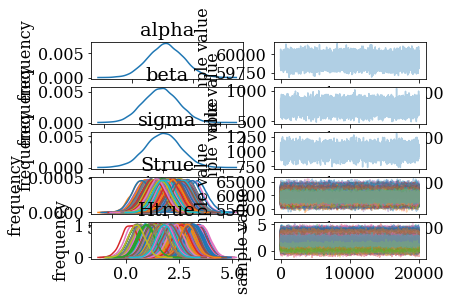

In [38]:
fit.plot()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


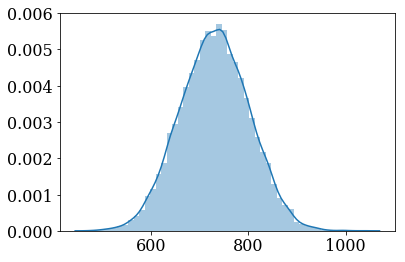

In [39]:
sns.distplot(fit['beta'])

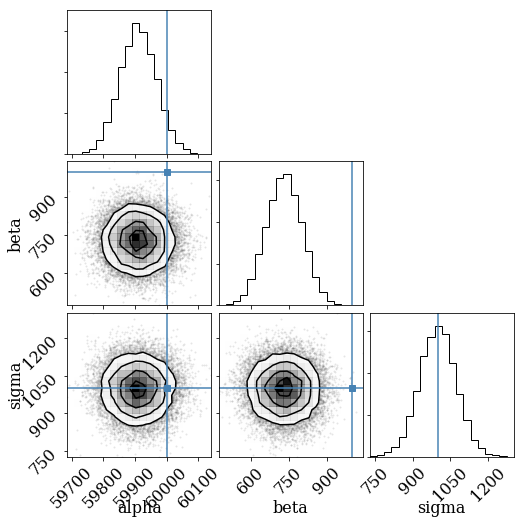

In [41]:
import corner
data = np.vstack([fit['alpha'], fit['beta'], fit['sigma']]).T
corner.corner(data, labels=['alpha', 'beta', 'sigma'], truths=[alpha, beta, Ssigma])
plt.show()

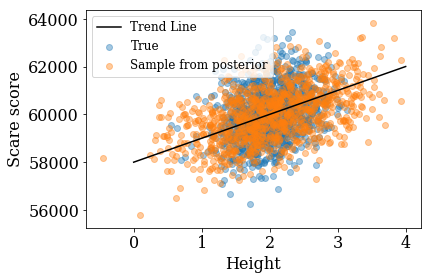

In [42]:
fig, ax = plt.subplots()
from matplotlib import rc
rc("font", family="serif", size=12)
ax.scatter(H_true, S_true, alpha=0.4, label='True')
ax.scatter(fit['Htrue'][100, :], fit['Strue'][100,:], alpha=0.4, label='Sample from posterior')
HH = np.linspace(0, 4, 100)
ax.plot(HH, alpha + (HH - 2) * beta, 'k-', label='Trend Line')
ax.set_xlabel('Height')
ax.set_ylabel('Scare score')
ax.legend()

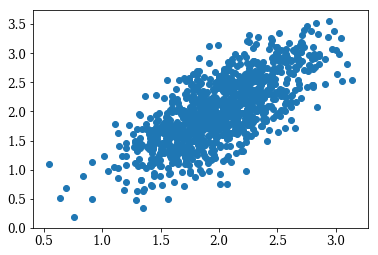

In [43]:
fig, ax = plt.subplots()
ax.scatter(H_true, fit['Htrue'].mean(axis=0))